Linear SVC
---
The model has been trained by nested GridSearchCV to search for the best parameters.  
The goal here is to calibrate the model to have an output matrix, in order to use it for soft voting.

In [1]:
import sys
sys.path.append("../")

import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

from utils import clean_text
from utils.metrics import Report

# Import Data

In [2]:
data_path = '../../data/'

In [3]:
with open(data_path + 'categories_string.csv') as f:
    categories = dict(map(lambda x:x.strip('\n').split(',')[::-1], f.readlines()[1:]))
    
X = pd.read_json(data_path + 'train.json').set_index('Id')
y = pd.read_csv(data_path + 'train_label.csv', index_col='Id', dtype={'Category': 'category'}).Category

# Preparing data
Words number per X

<AxesSubplot:>

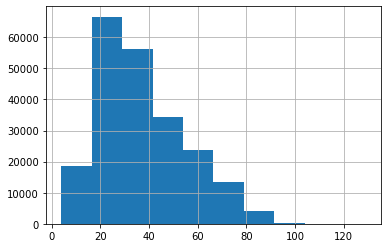

In [4]:
X['gender_name'] = X.gender
X.gender = X.loc[:, 'gender'].astype('category').cat.codes.rename("gender_cat")
X.description = X.description.apply(clean_text)

X.description.apply(lambda x:x.split().__len__()).hist()

Split to train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 1/3, random_state=42069)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

## Processing X
Converting description to TFDIF vector.  
Adding `gender` categorical feature to `x`.

In [6]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_desc = vectorizer.fit_transform(X_train.description)
x_train = hstack((X_desc, X_train.gender.to_numpy().reshape(-1,1))).tocsr()
del X_desc
print("Train: n_samples: %d, n_features: %d" % x_train.shape)

X_desc = vectorizer.transform(X_test.description)
x_test = hstack((X_desc, X_test.gender.to_numpy().reshape(-1,1))).tocsr()
del X_desc
print("Test: n_samples: %d, n_features: %d" % x_test.shape)

feature_names = vectorizer.get_feature_names() + ['gender_cat']

Train: n_samples: 144798, n_features: 132709
Test: n_samples: 72399, n_features: 132709


# Model
LinearSVC

## Training

In [7]:
cv_sets  = StratifiedKFold(10)

In [8]:
base = LinearSVC(C=0.2777777777777778, max_iter=5000, random_state=42069, tol=0.001)
model = CalibratedClassifierCV(
    base, method = 'isotonic',
    cv = cv_sets
)

model.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.2777777777777778,
                                                max_iter=5000,
                                                random_state=42069, tol=0.001),
                       cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                       method='isotonic')

## Evaluating

In [9]:
y_pred = model.predict(x_test)
report = Report(
    array_result = np.array([
        y_test.tolist(),
        y_pred.tolist(),
        X_test.gender_name.to_list()
    ]), categories = categories
)

print(report)

                   precision    recall  f1-score   diff_di   support

           pastor      0.671     0.735     0.701     0.339      4144
            model      0.741     0.743     0.742     3.859       530
               dj      0.826     0.776     0.800     0.294       245
        physician      0.881     0.811     0.844     0.073      4222
         comedian      0.854     0.506     0.636     0.019       312
software_engineer      0.680     0.649     0.664     0.798      1354
            nurse      0.736     0.694     0.714     0.675      3815
             poet      0.732     0.767     0.749     0.017      1465
          dentist      0.927     0.930     0.929     0.042      1826
     chiropractor      0.833     0.874     0.853     0.031      4902
        filmmaker      0.736     0.627     0.678     0.067      1986
        professor      0.808     0.720     0.761     0.029      1034
     yoga_teacher      0.852     0.709     0.774     1.939       285
     photographer      0.821     